In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [3]:
folder = os.path.join('activations', 'activations_minist_model.csv')
df = pd.read_csv(folder)
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.000000,0.000000,0.000000,0.399097,0.000000,0.000000,0.000000,0.000000,0.000000,...,-22.055817,-17.074514,-12.136678,-11.195572,-25.313034,-18.126488,-34.183750,-0.000019,-16.948915,-15.565269
1,2.0,0.000000,0.000000,3.122375,2.949144,2.404661,1.715258,0.338522,0.128126,1.610624,...,-15.903490,-8.095853,-0.000322,-11.127125,-27.803934,-17.198702,-14.273718,-19.698458,-13.450046,-30.231627
2,1.0,1.827291,1.748518,0.699948,0.539016,0.000000,0.628443,0.588888,0.000000,0.020213,...,-16.210146,-0.000385,-11.081397,-12.736809,-10.941203,-11.521659,-11.719425,-8.667583,-8.749459,-14.620137
3,0.0,0.000000,0.000000,0.614674,0.000000,1.043494,0.438858,0.000000,3.829711,2.498251,...,-0.000426,-13.427382,-9.176719,-14.582230,-15.579443,-13.185836,-8.165977,-12.736848,-13.246180,-10.434205
4,4.0,0.000000,0.000000,1.187802,0.092359,0.000000,0.000000,0.000000,2.307845,1.650951,...,-13.418967,-15.270522,-12.993325,-18.622927,-0.005147,-10.958460,-15.022395,-10.377352,-9.788157,-5.293344


In [4]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

# create new dataframe
df_layer1 = df[get_layer_columns('Layer1')]
df_layer1.head()

# create new dataframe
df_layer2 = df[get_layer_columns('Layer2')]
df_layer2.head()

# create new dataframe
df_layer3 = df[get_layer_columns('Layer3')]
df_layer3.head()

,Number,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,-22.055817,-17.074514,-12.136678,-11.195572,-25.313034,-18.126488,-34.183750,-0.000019,-16.948915,-15.565269
1,2.0,-15.903490,-8.095853,-0.000322,-11.127125,-27.803934,-17.198702,-14.273718,-19.698458,-13.450046,-30.231627
2,1.0,-16.210146,-0.000385,-11.081397,-12.736809,-10.941203,-11.521659,-11.719425,-8.667583,-8.749459,-14.620137
3,0.0,-0.000426,-13.427382,-9.176719,-14.582230,-15.579443,-13.185836,-8.165977,-12.736848,-13.246180,-10.434205
4,4.0,-13.418967,-15.270522,-12.993325,-18.622927,-0.005147,-10.958460,-15.022395,-10.377352,-9.788157,-5.293344


In [41]:
def plot_mean_and_std_bar_per_number(df: pd.DataFrame, title: str, numbers: list):
    if not numbers:
        raise ValueError('You must provide at least one number')

    for num in numbers:
        plt.figure(figsize=(20, 10))

        # Seleccionar las filas para cada número
        df_num = df[df['Number'] == num]
        df_num = df_num.drop(columns=['Number'])

        # Calcular la media y la desviación estándar
        mean = df_num.mean().sort_values(ascending=False)
        std = df_num.std()[mean.index]  # Asegurarse de que std corresponda a la media ordenada

        # Índices de las barras
        bar_indexes = range(1, len(mean) + 1)

        # Graficar la media y la desviación estándar
        plt.bar(bar_indexes, mean, yerr=std, label=f'Number {num}', alpha=0.7)
        plt.title(f'{title} - Number {num}')
        # get number of neurons per layer
        labels = [re.findall(r'\d+', c)[1] for c in mean.index]
        plt.xticks(ticks=bar_indexes, labels=labels, rotation=90)
        plt.legend()
        plt.show()

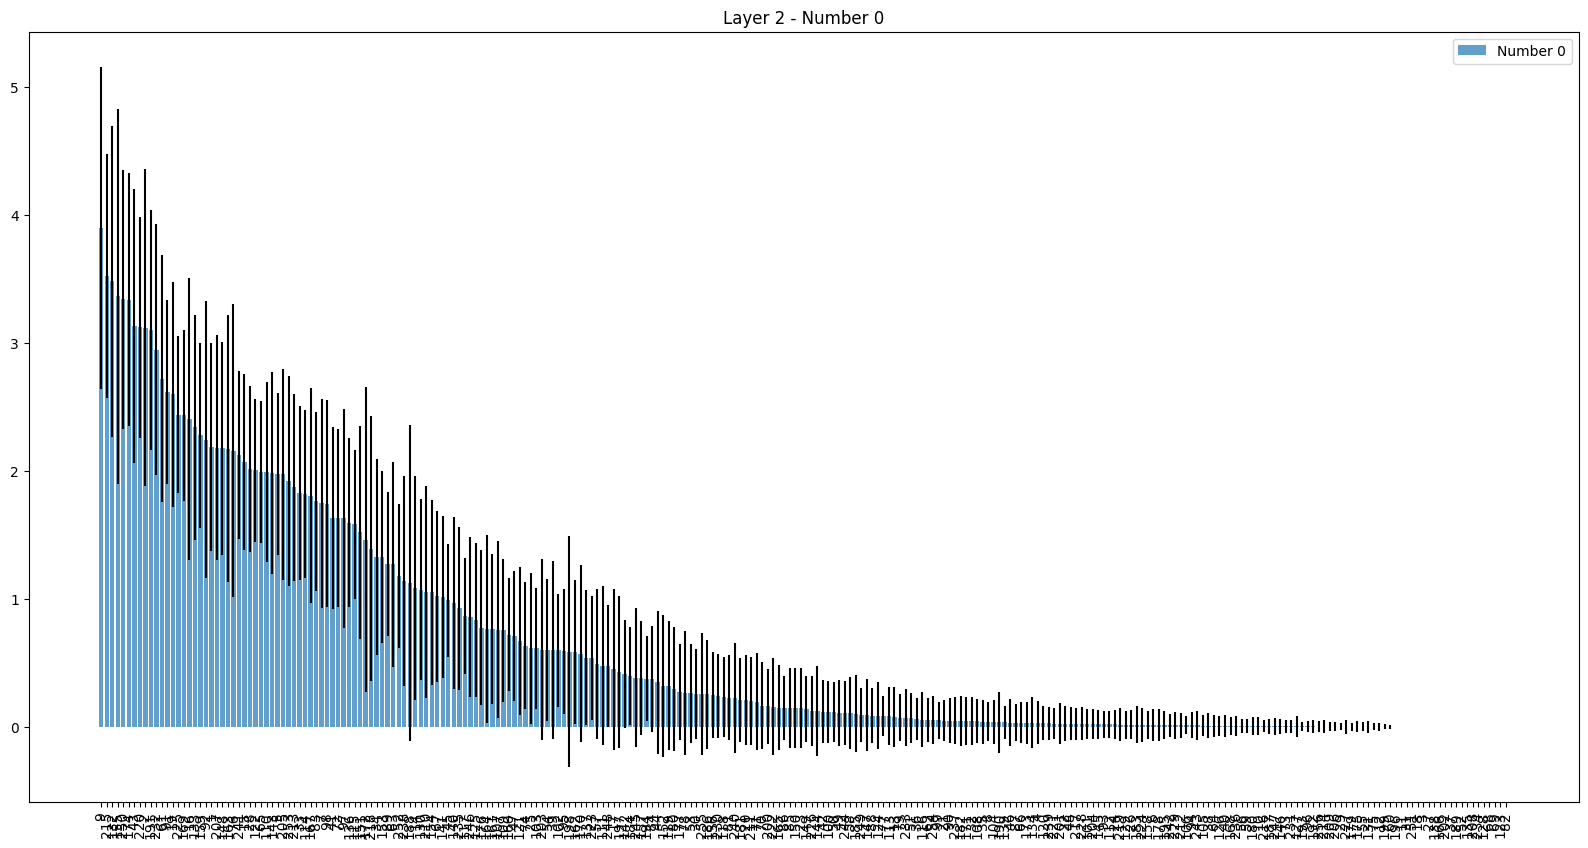

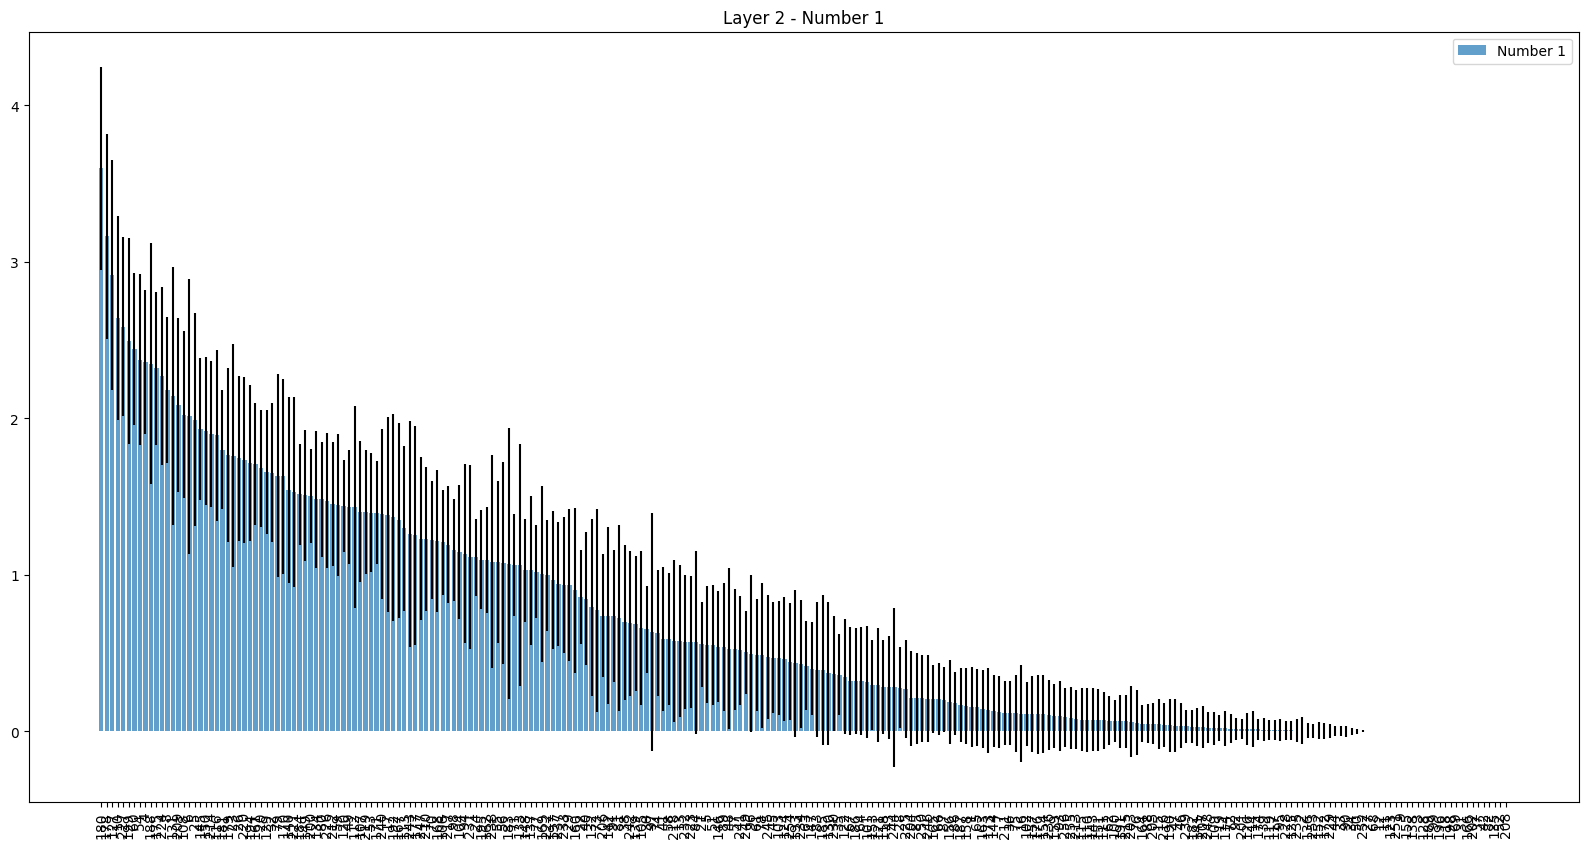

In [43]:
numbers = [0,1]
plot_mean_and_std_bar_per_number(df_layer2, 'Layer 2', numbers)

## GPT-2

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
def get_layer_columns(layer):
    layer_columns = [c for c in df.columns if layer in c]
    return layer_columns

In [9]:
folder = os.path.join('activations', 'gpt2.pickle')
df = pd.read_pickle(folder)
df.head()


,Input_text,Output_text,layer_1_Neuron1,layer_1_Neuron2,layer_1_Neuron3,layer_1_Neuron4,layer_1_Neuron5,layer_1_Neuron6,layer_1_Neuron7,layer_1_Neuron8,...,layer_12_Neuron3063,layer_12_Neuron3064,layer_12_Neuron3065,layer_12_Neuron3066,layer_12_Neuron3067,layer_12_Neuron3068,layer_12_Neuron3069,layer_12_Neuron3070,layer_12_Neuron3071,layer_12_Neuron3072
0,"1,2,3","1,2,3stroke",0.239007,0.221243,0.340456,0.133936,0.295884,0.00792,0.091352,0.814306,...,0.119236,0.14644,0.662931,0.175894,0.051859,0.0217,0.336449,0.187168,0.115233,0.228487
1,"4,5,6","4,5,6 abdomen",0.239007,0.221243,0.340456,0.133936,0.295884,0.00792,0.091352,0.814306,...,0.119236,0.14644,0.662931,0.175894,0.051859,0.0217,0.336449,0.187168,0.115233,0.228487
2,"7,8,9","7,8,9Basic",0.239007,0.221243,0.340456,0.133936,0.295884,0.00792,0.091352,0.814306,...,0.119236,0.14644,0.662931,0.175894,0.051859,0.0217,0.336449,0.187168,0.115233,0.228487
3,"10,11,12","10,11,12 listings",0.239007,0.221243,0.340456,0.133936,0.295884,0.00792,0.091352,0.814306,...,0.119236,0.14644,0.662931,0.175894,0.051859,0.0217,0.336449,0.187168,0.115233,0.228487
4,"13,14,15","13,14,15 wilderness",0.239007,0.221243,0.340456,0.133936,0.295884,0.00792,0.091352,0.814306,...,0.119236,0.14644,0.662931,0.175894,0.051859,0.0217,0.336449,0.187168,0.115233,0.228487


In [10]:
def plot_mean_and_std_bar_per_number(df: pd.DataFrame, title: str, inputs: list):
    if not inputs:
        raise ValueError('You must provide at least one input')

    for text in inputs:
        plt.figure(figsize=(20, 10))

        # Seleccionar las filas para cada número
        df_num = df[df['Input_text'] == text]
        df_num = df_num.drop(columns=['Input_text'])
        df_num = df_num.drop(columns=['Output_text'])

        # Calcular la media y la desviación estándar
        mean = df_num.mean().sort_values(ascending=False)
        std = df_num.std()[mean.index]  # Asegurarse de que std corresponda a la media ordenada

        # Índices de las barras
        bar_indexes = range(1, len(mean) + 1)

        # Graficar la media y la desviación estándar
        plt.bar(bar_indexes, mean, yerr=std, label=f'Input {text}', alpha=0.7)
        plt.title(f'{title} - Input {text}')
        # get number of neurons per layer
        # labels = [re.findall(r'\d+', c)[1] for c in mean.index]
        #plt.xticks(ticks=bar_indexes, labels=labels, rotation=90)
        plt.legend()
        plt.show()

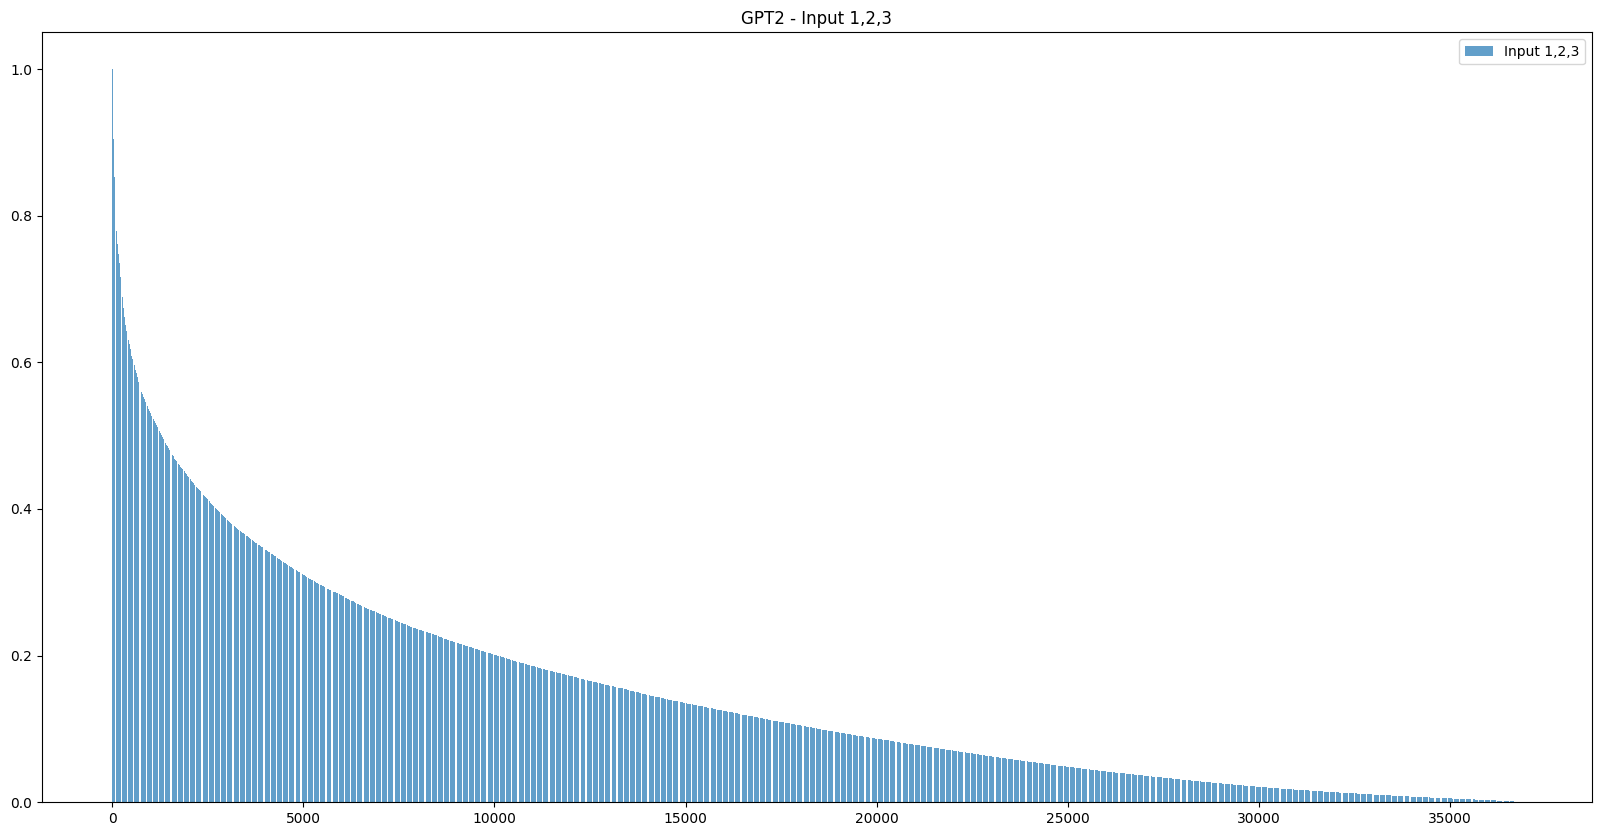

In [11]:
example = ['1,2,3']
plot_mean_and_std_bar_per_number(df, 'GPT2', example)

In [7]:
# split dataframe into layers 
layers_activations = []
for i in range(1,12):
    layers_activations.append(df[get_layer_columns(f'layer_{i}')])

In [8]:
layers_activations[0].head()

,layer_1_Neuron1,layer_1_Neuron2,layer_1_Neuron3,layer_1_Neuron4,layer_1_Neuron5,layer_1_Neuron6,layer_1_Neuron7,layer_1_Neuron8,layer_1_Neuron9,layer_1_Neuron10,...,layer_12_Neuron3063,layer_12_Neuron3064,layer_12_Neuron3065,layer_12_Neuron3066,layer_12_Neuron3067,layer_12_Neuron3068,layer_12_Neuron3069,layer_12_Neuron3070,layer_12_Neuron3071,layer_12_Neuron3072
0,0.029089,-0.000874,0.015843,0.016786,0.013312,0.012519,0.002057,0.007283,0.014246,0.0042,...,0.034089,0.000012,-0.005364,0.028921,0.025151,0.03576,0.013275,0.057124,0.010753,0.00206
1,0.029089,-0.000874,0.015843,0.016786,0.013312,0.012519,0.002057,0.007283,0.014246,0.0042,...,0.034089,0.000012,-0.005364,0.028921,0.025151,0.03576,0.013275,0.057124,0.010753,0.00206
2,0.029089,-0.000874,0.015843,0.016786,0.013312,0.012519,0.002057,0.007283,0.014246,0.0042,...,0.034089,0.000012,-0.005364,0.028921,0.025151,0.03576,0.013275,0.057124,0.010753,0.00206
3,0.029089,-0.000874,0.015843,0.016786,0.013312,0.012519,0.002057,0.007283,0.014246,0.0042,...,0.034089,0.000012,-0.005364,0.028921,0.025151,0.03576,0.013275,0.057124,0.010753,0.00206
4,0.029089,-0.000874,0.015843,0.016786,0.013312,0.012519,0.002057,0.007283,0.014246,0.0042,...,0.034089,0.000012,-0.005364,0.028921,0.025151,0.03576,0.013275,0.057124,0.010753,0.00206


In [22]:

def find_low_activation_neurons(df: pd.DataFrame, layer: str, threshold: int = 0.5):
    """
    Finds the low activation neurons that are below the given threshold 

    Parameters:
    - df (DataFrame): The input DataFrame containing activation values.
    - threshold (float): The threshold value for determining low activation.

    Returns:
    - low_neurons (list): A list of indices of the low activation neurons that are below the threshold
    """
    # get neurons of the layer not use get_layer_columns
    layer_columns = [c for c in df.columns if layer in c]
    print(layer_columns)
    # get mean of the layer
    mean_df = df[layer_columns].mean()
    """mean_df = df.mean()
    threshold_df = threshold * mean_df.max()
    print(f'The threshold is {threshold_df}')
    low_neurons = mean_df[mean_df < threshold_df].index
    return low_neurons"""
    


In [23]:
find_low_activation_neurons(layers_activations[0], 'layer_1')

['layer_1_Neuron1', 'layer_1_Neuron2', 'layer_1_Neuron3', 'layer_1_Neuron4', 'layer_1_Neuron5', 'layer_1_Neuron6', 'layer_1_Neuron7', 'layer_1_Neuron8', 'layer_1_Neuron9', 'layer_1_Neuron10', 'layer_1_Neuron11', 'layer_1_Neuron12', 'layer_1_Neuron13', 'layer_1_Neuron14', 'layer_1_Neuron15', 'layer_1_Neuron16', 'layer_1_Neuron17', 'layer_1_Neuron18', 'layer_1_Neuron19', 'layer_1_Neuron20', 'layer_1_Neuron21', 'layer_1_Neuron22', 'layer_1_Neuron23', 'layer_1_Neuron24', 'layer_1_Neuron25', 'layer_1_Neuron26', 'layer_1_Neuron27', 'layer_1_Neuron28', 'layer_1_Neuron29', 'layer_1_Neuron30', 'layer_1_Neuron31', 'layer_1_Neuron32', 'layer_1_Neuron33', 'layer_1_Neuron34', 'layer_1_Neuron35', 'layer_1_Neuron36', 'layer_1_Neuron37', 'layer_1_Neuron38', 'layer_1_Neuron39', 'layer_1_Neuron40', 'layer_1_Neuron41', 'layer_1_Neuron42', 'layer_1_Neuron43', 'layer_1_Neuron44', 'layer_1_Neuron45', 'layer_1_Neuron46', 'layer_1_Neuron47', 'layer_1_Neuron48', 'layer_1_Neuron49', 'layer_1_Neuron50', 'layer_1